In [29]:
import pandas as pd
import numpy as np
import pickle, gc
from scipy.sparse import csc_matrix,csr_matrix,eye,bmat
from scipy.sparse.linalg import eigs,inv,gmres
from scipy.stats import rankdata
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def load_sparse_csc(filename):
    loader = np.load(filename)
    return csc_matrix((loader['data'],loader['indices'],loader['indptr']),shape = loader['shape'])

def alpha(A,a):
    A.data[A.data<1e-6] = 0
    A.data[np.isnan(A.data)]=0
    w,v = eigs(A,k=1,which='LM')
    return a/w[0].real

def solve(mat,mat_1,a,min_reps,x_guess=None,x_guess1=None):
    mat.data[mat_1.data<1e-6] = 0
    mat_1.data[mat_1.data<1e-6] = 0
    mat.data[np.isnan(mat.data)] = 0
    mat_1.data[np.isnan(mat_1.data)] = 0

    alpha_ = alpha(mat,a)

    S = eye(mat.shape[0],format='csc')-alpha_*mat
    w_a = gmres(S,mat.sum(1),x0=x_guess)[0]

    S = eye(mat_1.shape[0],format='csc')-alpha_*mat_1 
    w_g = gmres(S,mat_1.sum(1),x0=x_guess1)[0]

    solve.w_a = w_a
    solve.w_g = w_g
    w_a[w_g<min_reps] = 0
    return ((w_a/w_g),w_g)

def rank(a,mask):
    res = np.ones_like(a)
    res[mask] = rankdata(a[mask])/mask.sum()
    res[~mask] = np.nan
    return res

In [3]:
with open('PickleFiles/num_to_ind_shot.pkl','r') as pickleFile:
    num_to_ind = pickle.load(pickleFile)

ind_to_num = dict((value,key) for key,value in num_to_ind.iteritems())
    
with open('PickleFiles/player_names.pkl','r') as pickleFile:
    num_to_name = pickle.load(pickleFile)

with open('PickleFiles/broadie_tourn_map.pkl','r') as pickleFile:
    broadie_tourn_map = pickle.load(pickleFile)
    
name_to_num = {value:key for key,value in num_to_name.iteritems()}

In [4]:
rdata = pd.read_csv('data/round.csv')

In [5]:
cols = ['Year','Permanent_Tournament_#','tourn_num']
data = pd.concat([pd.read_csv('data/%d.csv' % (year), usecols=cols) for year in range(2003,2019)])
tups = data.sort_values('tourn_num')\
           .drop_duplicates()[['Year','Permanent_Tournament_#']].values.tolist()

In [6]:
data = None
gc.collect()

56

In [7]:
cats = ['tee3','tee45','green0','green5','green10','green20','rough0','rough90',
        'rough375','fairway0','fairway300','fairway540','bunker','other']

In [8]:
x,y = defaultdict(list), []
for tourn_num,(year,tourn) in enumerate(tups):
    rtourn = rdata[(rdata.Tournament_Year==year) & (rdata['Permanent_Tournament_#']==tourn)]
    players = pd.unique(rtourn.Player_Number)
    if not len(players): continue
    finishing_positions = rtourn.groupby('Player_Number').Finishing_Position.mean().to_dict()
    finishing_positions = np.array([finishing_positions[player] for player in players])
    players = [num_to_ind[player] for player in players]
    for cat in cats:
        A = load_sparse_csc('cats/cats_w-0.8-0.7-0.8/%s_%d.npz' % (cat,tourn_num))
        G = load_sparse_csc('cats/cats_w-0.8-0.7-0.8/%s_%d_g.npz' % (cat,tourn_num))
        rats, _ = solve(A,G,.95,0)
        x[cat].extend(rank(rats[players],~np.isnan(rats[players])).tolist())
    y.extend(finishing_positions.tolist())

/Users/adamlevin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in divide
/Users/adamlevin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in double_scalars


In [9]:
for cat in cats:
    print cat,np.isnan(x[cat]).mean()

tee3 0.00264456500995
tee45 0.00259003789634
green0 0.00260366967475
green5 0.00353063060607
green10 0.0030262548052
green20 0.00293083235639
rough0 0.0212928378636
rough90 0.0603069876496
rough375 0.0090651326372
fairway0 0.00944682243245
fairway300 0.00317620436762
fairway540 0.00541181602552
bunker 0.0159900760653
other 0.513168297936


In [10]:
corrs = {}
for cat in cats:
    x_,y_ = np.array(x[cat]), np.array(y)
    print cat,np.corrcoef(x_[~np.isnan(x_)],y_[~np.isnan(x_)])[0,1]
    corrs[cat] = -1*np.corrcoef(x_[~np.isnan(x_)],y_[~np.isnan(x_)])[0,1]

tee3 -0.326943147677
tee45 -0.352121082211
green0 -0.21240214198
green5 -0.301916548006
green10 -0.306349009882
green20 -0.269737011561
rough0 -0.142249597103
rough90 -0.0354136235012
rough375 -0.213829025567
fairway0 -0.175199859071
fairway300 -0.316564183729
fairway540 -0.21934411354
bunker -0.148015826591
other -0.0556075874654


In [11]:
for key in sorted(corrs,key=corrs.get,reverse=True):
    print key,corrs[key]

tee45 0.352121082211
tee3 0.326943147677
fairway300 0.316564183729
green10 0.306349009882
green5 0.301916548006
green20 0.269737011561
fairway540 0.21934411354
rough375 0.213829025567
green0 0.21240214198
fairway0 0.175199859071
bunker 0.148015826591
rough0 0.142249597103
other 0.0556075874654
rough90 0.0354136235012


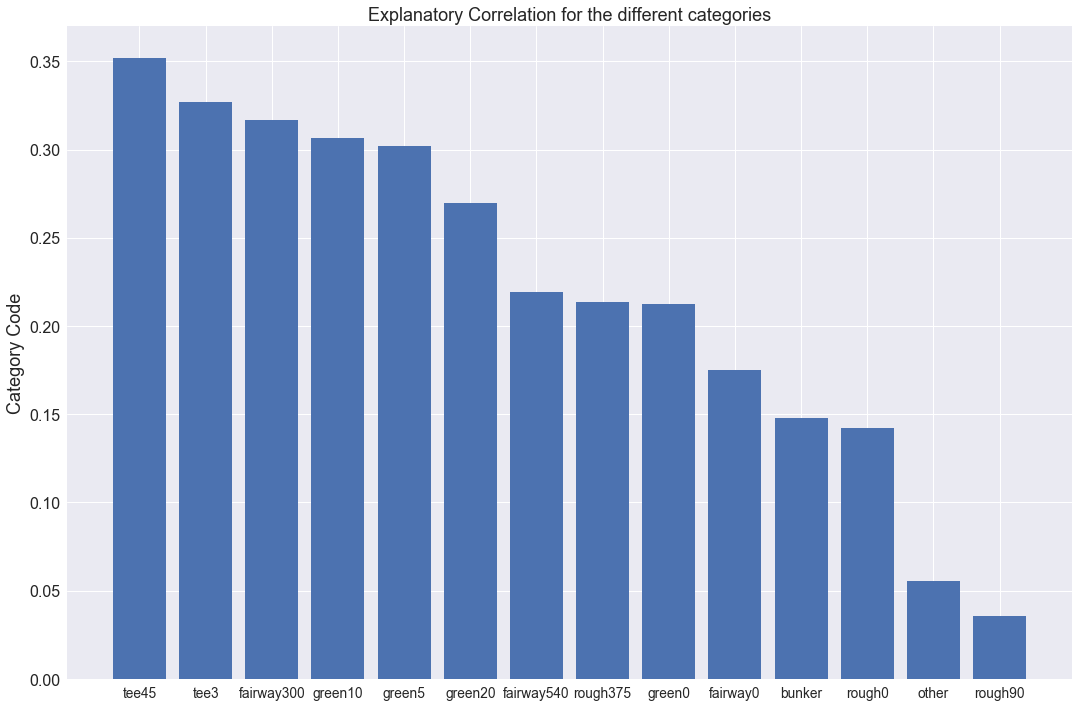

In [32]:
fig,ax = plt.subplots(1,1,figsize=(18,12))
x_ticks = np.array(corrs.keys())
y = np.array(corrs.values())
x_ticks = x_ticks[np.argsort(y)[::-1]]
y = np.sort(y)[::-1]
plt.bar(range(len(corrs)),y)
plt.xticks(range(len(corrs)),x_ticks,fontsize=13.8);
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)
plt.title('Explanatory Correlation for the different categories',fontsize=18);
plt.ylabel('Correlation',fontsize=18)
plt.ylabel('Category Code',fontsize=18);